## <font color = '#ACBCFF'> LATENT DIRICHLET ALLOCATION 


>Idea:
    <ol>
    <li>LDA for all tweets about Tesla, Dogecoin, and Bitcoin</li>
    </ol>

Source: 
- https://www.kaggle.com/code/imnoob/topic-modelling-lda-on-trip-advisor-dataset/notebook and 
- https://blog.devgenius.io/nlp-topic-modeling-lda-latent-dirichlet-allocation-f87679750e34

In [1]:
#importing libaries
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

/opt/homebrew/Caskroom/miniforge/base/envs/conda_env/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
df = pd.read_csv('../data/dogecoin_tweets.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,date,tweet,tweet_clean_func,tweet_emojis,tweet_clean,hashtag,vader_clean_scores,vader_clean_compound,vader_negative,vader_positive,vader_neutral,vader_clean_sentiment,vader_clean_polarity,blob_polarity,blob_subjectivity,blob_sentiment,sentiment_flair,probability_flair,classified_similarly
0,2019-04-02,Dogecoin value may vary https://t.co/UWerAhPv63,"['dogecoin', 'value', 'may', 'vary']",[],dogecoin value may vary,[],"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.3400,0.0,0.444,0.556,positive,1.0,0.0,0.000,neutral,NEGATIVE,0.981104,0
1,2019-04-02,Dogecoin rulz https://t.co/flWWUgAgLU,"['dogecoin', 'rulz']",[],dogecoin rulz,[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0,0.000,1.000,neutral,NaN,0.0,0.000,neutral,NEGATIVE,0.992264,1
2,2019-04-02,@Tom_Heats Dogecoin might be my fav cryptocurr...,"['dogecoin', 'might', 'be', 'my', 'fav', 'cryp...",[],dogecoin might fav cryptocurrency pretty cool,[],"{'neg': 0.0, 'neu': 0.261, 'pos': 0.739, 'comp...",0.8176,0.0,0.739,0.261,positive,1.0,0.3,0.825,positive,POSITIVE,0.962192,1
3,2020-04-25,@28delayslater @justpaulinelol Dogecoin Mode,"['dogecoin', 'mode']",[],dogecoin mode,[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0,0.000,1.000,neutral,NaN,0.0,0.000,neutral,POSITIVE,0.990528,1
4,2021-02-04,Dogecoin is the people’s crypto,"['dogecoin', 'is', 'the', 'people', '’', 's', ...",[],dogecoin people crypto,[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0,0.000,1.000,neutral,NaN,0.0,0.000,neutral,NEGATIVE,0.945280,1


In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
#         sent = re.sub(r'http\S+', ' ', sent)  # remove links 
#         sent = re.sub(r'https\S+', ' ', sent)  # remove links
#         sent = re.sub(r'pic.twitter\S+', ' ', sent)  # remove links
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.tweet.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['dogecoin', 'value', 'may', 'vary', 'https', 'co', 'uwerahpv']]


In [4]:
# !python -m spacy download en_core_web_sm

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.047*"day" + 0.027*"appease" + 0.027*"believe" + 0.027*"star" + '
  '0.027*"sirius" + 0.027*"afternoon" + 0.027*"ancient" + 0.027*"weather" + '
  '0.027*"begin" + 0.027*"rage"'),
 (1,
  '0.068*"moon" + 0.058*"literal" + 0.037*"dogecoin" + 0.033*"put" + '
  '0.033*"spacex" + 0.033*"dumb" + 0.008*"suggest" + 0.008*"haha" + '
  '0.008*"change" + 0.008*"phase"'),
 (2,
  '0.238*"dogecoin" + 0.082*"existence" + 0.082*"pay" + 0.082*"mine" + '
  '0.082*"proof" + 0.020*"buyable" + 0.015*"lil" + 0.015*"hodler" + '
  '0.015*"buy" + 0.015*"toddler"'),
 (3,
  '0.133*"dogecoin" + 0.119*"support" + 0.104*"keep" + 0.020*"coin" + '
  '0.020*"concentration" + 0.020*"full" + 0.020*"issue" + 0.020*"imo" + '
  '0.020*"major" + 0.020*"holder"'),
 (4,
  '0.115*"dogecoin" + 0.028*"people" + 0.018*"bro" + 0.018*"humble" + '
  '0.018*"humor" + 0.018*"love" + 0.018*"part" + 0.018*"sense" + 0.018*"big" + '
  '0.018*"billy"'),
 (5,
  '0.056*"pretty" + 0.054*"dogecoin" + 0.035*"suggest" + 0.035*"phase" + '

In [7]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.8330,"dogecoin, support, keep, coin, concentration, ...","[dogecoin, value, vary, uwerahpv]"
1,1,2,0.7217,"dogecoin, existence, pay, mine, proof, buyable...","[dogecoin, rulz]"
2,2,5,0.8602,"pretty, dogecoin, suggest, phase, haha, fee, c...","[dogecoin, fav, cryptocurrency, pretty, cool]"
3,3,2,0.7217,"dogecoin, existence, pay, mine, proof, buyable...","[dogecoin, mode]"
4,4,4,0.7910,"dogecoin, people, bro, humble, humor, love, pa...","[dogecoin, people, crypto]"


In [8]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9559,"day, appease, believe, star, sirius, afternoon, ancient, weather, begin, rage","[day, afternoon, ancient, roman, sacrifice, dogecoin, begin, doge, day, appease, rage, sirius, b..."
1,1,0.8795,"moon, literal, dogecoin, put, spacex, dumb, suggest, haha, change, phase","[spacex, put, literal, dogecoin, literal, moon]"
2,2,0.8610,"dogecoin, existence, pay, mine, proof, buyable, lil, hodler, buy, toddler","[buy, dogecoin, lil, toddler, hodler]"
3,3,0.9359,"dogecoin, support, keep, coin, concentration, full, issue, imo, major, holder","[major, dogecoin, holder, sell, coin, full, support, much, concentration, real, issue, imo]"
4,4,0.9242,"dogecoin, people, bro, humble, humor, love, part, sense, big, billy","[humble, bro, billy, sense, humor, big, part, people, love, dogecoin]"
5,5,0.8602,"pretty, dogecoin, suggest, phase, haha, fee, change, base, awesome, cryptocurrency","[dogecoin, fav, cryptocurrency, pretty, cool]"


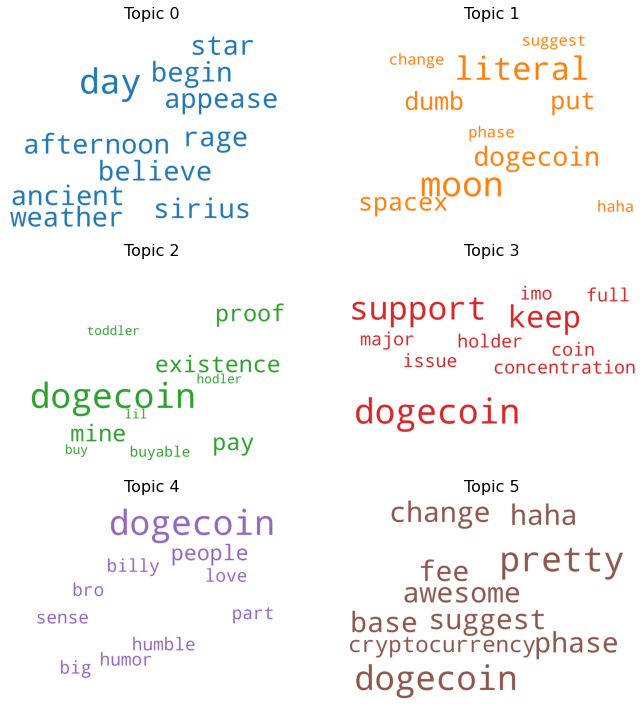

In [9]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


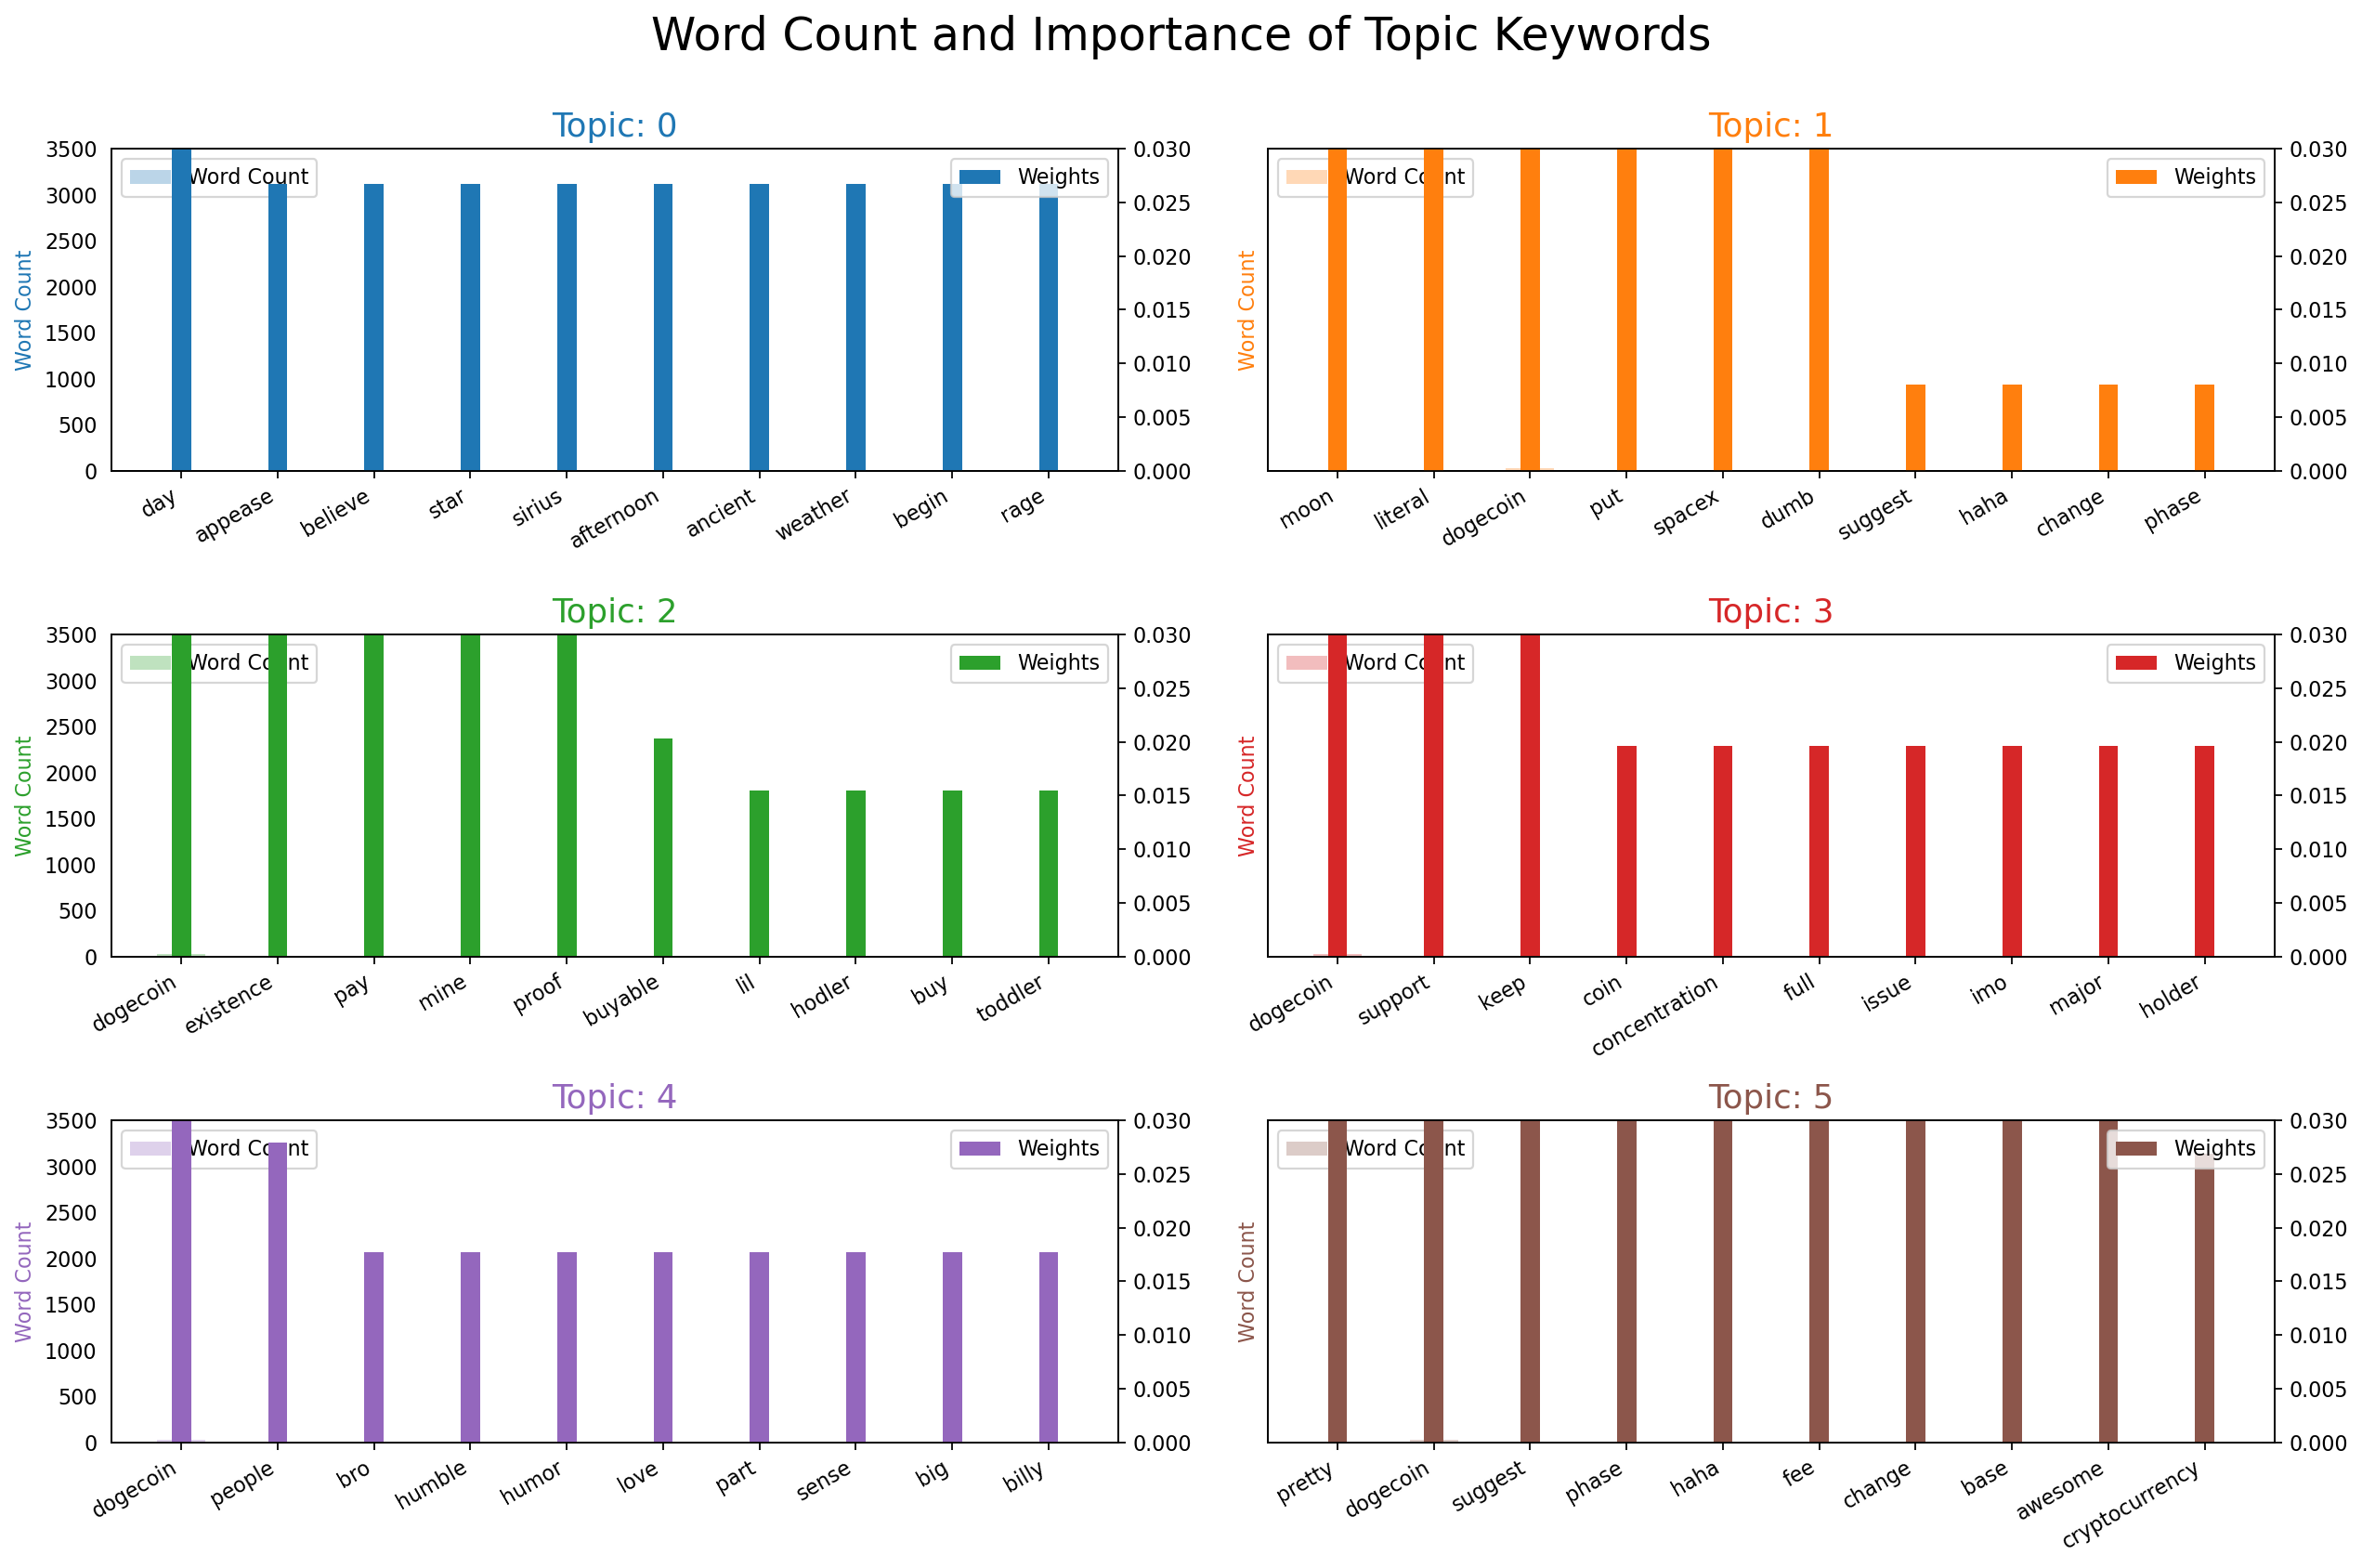

In [10]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [11]:
# ! pip install pyLDAvis

In [12]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.022530  0.082050       1        1  35.163276
0     -0.067327 -0.005912       2        1  15.919245
3      0.015208 -0.102193       3        1  15.511083
2      0.154379  0.020800       4        1  13.460591
5     -0.040375 -0.000418       5        1  12.177417
1     -0.039355  0.005674       6        1   7.768388, topic_info=            Term       Freq      Total Category  logprob  loglift
0       dogecoin  13.000000  13.000000  Default  30.0000  30.0000
26       support   2.000000   2.000000  Default  29.0000  29.0000
93          keep   2.000000   2.000000  Default  28.0000  28.0000
96           pay   1.000000   1.000000  Default  27.0000  27.0000
95          mine   1.000000   1.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
77  trillionaire   0.078460   1.248831   Topic6  -4.8263  -0.2123
93          keep   0.078459   2.543347   Topic6  -4.8264  -0.9235
67      discount   0.078459   1.248834   Topic6  -4.8264  -0.2123
68           dog   0.078459   1.248834   Topic6  -4.8264  -0.2123
69       tuition   0.078459   1.248834   Topic6  -4.8264  -0.2123

[277 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
55        1  0.800745       ability
71        1  0.800745        accept
56        1  0.800745        action
28        2  0.984140     afternoon
78        1  0.800745        always
...     ...       ...           ...
26        3  0.705782       support
77        1  0.800749  trillionaire
69        1  0.800747       tuition
43        2  0.984140       weather
84        1  0.800745         write

[74 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 3, 6, 2])

In [13]:
pyLDAvis.save_html(vis, 'LDA_Dogecoin.html')